In [1]:
import sys
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from glob import glob
import numpy as np
import torch
from random import shuffle
import random
from numpy import random as npr
import pandas as pd
import imageio
from PIL import Image


class MethaneLoader(DataLoader):

    def __init__(self, device, mode, plume_id, red=False, alli=False, channels=12):
        self.device = device
        self.mode = mode
        self.reduce = red
        self.channels = channels

        if mode == "train":
            persist = False
        else:
            persist = True
        
        if plume_id is not None:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/*/{}.npy".format(mode, plume_id)))
#             self.neg_labels = sorted(
#                 glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/{}.npy".format(mode, plume_id)))
            self.neg_labels = []
        else:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/*.npy".format(mode)))
            self.neg_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/neg/*.npy".format(mode)))

        self.labels = self.pos_labels+self.neg_labels  # None
        
        if not alli:
            self.sample_labels_and_combine(persist=persist)

    def sample_labels_and_combine(self, persist=False):
        """
        Sample a subset of negative labels for each epoch
        """
        # if self.mode == "test":
        if self.mode in ["val"]:
            self.labels = self.pos_labels+self.neg_labels
        else:
            if persist:
                random.seed(555)

            shuffle(self.neg_labels)
            self.labels = self.pos_labels + \
                self.neg_labels[:len(self.pos_labels)]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):

        f = self.labels[index]
        # print(f)

        plume_id = int(f.split("/")[-1].split(".")[0])
        # print(plume_id)

        target = np.load(f)
        context = np.load(
            "/kaggle/input/ch4net-dataset/data/{}/s2/{}.npy".format(self.mode, plume_id))

        if self.channels == 2:
            context = context[..., 10:]
        if self.channels == 5:
            context = np.concatenate(
                [context[..., 1:4], context[..., 10:]], axis=-1)
        
        if self.mode == "train":
            # rotate by 90, 180, 270 degrees
            degrees = npr.choice([0, 90, 180, 270])
            context = np.rot90(context, k=degrees//90)
            target = np.rot90(target, k=degrees//90)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=0)
                target = np.flip(target, axis=0)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=1)
                target = np.flip(target, axis=1)

        # Crop to centre
        # x_c = target.shape[0]//2
        # y_c = target.shape[1]//2
        s = 64

        if self.mode == "train":
            rng = npr.RandomState()
            mid_loc_x = rng.randint(s, target.shape[0]-s)
            mid_loc_y = rng.randint(s, target.shape[1]-s)

        else:
            mid_loc_x = target.shape[0]//2
            mid_loc_y = target.shape[1]//2

        target = target[mid_loc_x-s:mid_loc_x+s,
                        mid_loc_y-s: mid_loc_y+s]

        context = context[mid_loc_x-s:mid_loc_x+s,
                          mid_loc_y-s: mid_loc_y+s, :]

        ### These are not defined before and not necessary for training. 
        ### But these are used in evaluation outputs
#         diff_img = np.array(diff_img[mid_loc_x-s:mid_loc_x+s,
#                                      mid_loc_y-s:mid_loc_y+s, :])
#         diff_img_g = np.array(diff_img_g[mid_loc_x-s:mid_loc_x+s,
#                                          mid_loc_y-s:mid_loc_y+s])
#         rgb_img = np.array(rgb_img[mid_loc_x-s:mid_loc_x+s,
#                                    mid_loc_y-s:mid_loc_y+s, :])

        if self.reduce:
            target = np.array([np.int(target.any())])

        # if self.mode == "test":
            # print("Plume ID: {}, date: {}".format(plume_id, date))

        d = {"pred": torch.from_numpy(context.copy()).float().to(self.device).permute(2, 0, 1)/255,
             "target": torch.from_numpy(target.copy()).float().to(self.device)}
        
        # Print the size of the image tensor
#         print("Image tensor size (context):", d["pred"].size())
#         print("Image tensor size (target):", d["target"].size())

        return d

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    """
    Base MLP module with ReLU activation
    Parameters:
    -----------
    in_channels: Int
        Number of input channels
    out_channels: Int
        Number of output channels
    h_channels: Int
        Number of hidden channels
    h_layers: Int
        Number of hidden layers
    """

    def __init__(self, 
                in_channels, 
                out_channels, 
                h_channels=64,
                h_layers=4):

        super().__init__()

        def hidden_block(h_channels):
            h = nn.Sequential(
            nn.Linear(h_channels, h_channels),
            nn.ReLU())
            return h

        # Model
        
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.ReLU(),
            *[hidden_block(h_channels) for _ in range(h_layers)],
            nn.Linear(h_channels, out_channels) 
        )

    def forward(self, x):
        return self.mlp(x)

class Unet(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 div_factor=8,
                 prob_output=True,
                 class_output=False

    ):
        super(Unet, self).__init__()

        self.n_channels = in_channels
        self.bilinear = True
        self.sigmoid = nn.Sigmoid()
        self.prob_output = prob_output
        self.class_output = class_output

        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        def down(in_channels, out_channels):
            return nn.Sequential(
                nn.MaxPool2d(2),
                double_conv(in_channels, out_channels)
            )

        class up(nn.Module):
            def __init__(self, in_channels, out_channels, bilinear=True):
                super().__init__()

                if bilinear:
                    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                else:
                    self.up = nn.ConvTranpose2d(in_channels // 2, in_channels // 2,
                                                kernel_size=2, stride=2)

                self.conv = double_conv(in_channels, out_channels)

            def forward(self, x1, x2):
                x1 = self.up(x1)
                # [?, C, H, W]
                diffY = x2.size()[2] - x1.size()[2]
                diffX = x2.size()[3] - x1.size()[3]

                x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2])
                x = torch.cat([x2, x1], dim=1) ## why 1?
                return self.conv(x)

        self.inc = double_conv(self.n_channels, 64//div_factor)
        self.down1 = down(64//div_factor, 128//div_factor)
        self.down2 = down(128//div_factor, 256//div_factor)
        self.down3 = down(256//div_factor, 512//div_factor)
        self.down4 = down(512//div_factor, 512//div_factor)
        self.up1 = up(1024//div_factor, 256//div_factor)
        self.up2 = up(512//div_factor, 128//div_factor)
        self.up3 = up(256//div_factor, 64//div_factor)
        self.up4 = up(128//div_factor, 128//div_factor)
        self.out = nn.Conv2d(128//div_factor, 1, kernel_size=1)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        #return self.out(x).permute(0,2,3,1)

        if self.prob_output:
            x = self.out(x)
            return self.sigmoid(x).permute(0,2,3,1)
        else:
            return self.out(x).permute(0,2,3,1)

In [3]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class UNet_Attention(nn.Module):
    def __init__(self, img_ch=12, output_ch=1):
        super(UNet_Attention, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        return out

# Example usage:

# Instantiate the model
model = UNet_Attention(img_ch=12, output_ch=1)

# Example input tensor with shape [batch_size, channels, height, width]
input_tensor = torch.randn(16, 12, 128, 128)  # Example batch size of 16

# Example target tensor with shape [batch_size, height, width]
target_tensor = torch.randn(16, 128, 128)

# Adjust the target tensor to match the output shape
target_tensor = target_tensor.unsqueeze(1)

# Forward pass
output = model(input_tensor)

# Check output shape
print(f"Output shape: {output.shape}")  # Should be [16, 1, 128, 128]
print(f"Target shape: {target_tensor.shape}")  # Should be [16, 1, 128, 128]

Output shape: torch.Size([16, 1, 128, 128])
Target shape: torch.Size([16, 1, 128, 128])


In [4]:
import torch
import torch.nn as nn

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

In [5]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(out_ch))

    def forward(self, x):
        x = self.conv1(x) + self.conv2(x)
        return x

class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class Res_UNet_Channel_Attention(nn.Module):
    def __init__(self, img_ch=12, output_ch=1):
        super(Res_UNet_Channel_Attention, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16, n1 * 32]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])
        self.conv6 = conv_block(filters[4], filters[5])

        self.Up6 = up_conv(filters[5], filters[4])
        self.Att6 = Attention_block(F_g=filters[4], F_l=filters[4], F_int=filters[3])
        self.Up_conv6 = conv_block(filters[5], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)
        
        self.Ch_att1 = ChannelAttention(in_planes=filters[0], ratio=8)
        self.Ch_att2 = ChannelAttention(in_planes=filters[1], ratio=8)
        self.Ch_att3 = ChannelAttention(in_planes=filters[2], ratio=8)
        self.Ch_att4 = ChannelAttention(in_planes=filters[3], ratio=8)
        self.Ch_att5 = ChannelAttention(in_planes=filters[4], ratio=8)


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        e6 = self.Maxpool5(e5)
        e6 = self.conv6(e6)

        d6 = self.Up6(e6)

#         x5 = self.Att6(g=d6, x=self.Ch_att5(e5))
        x5 = self.Att6(g=d6, x=e5)
        d6 = torch.cat((x5, d6), dim=1)
        d6 = self.Up_conv6(d6)

        d5 = self.Up5(d6)
#         x4 = self.Att5(g=d5, x=self.Ch_att4(e4))
        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
#         x3 = self.Att4(g=d4, x=self.Ch_att3(e3))
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
#         x2 = self.Att3(g=d3, x=self.Ch_att2(e2))
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
#         x1 = self.Att2(g=d2, x=self.Ch_att1(e1))
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        return out

# Example usage:

# Instantiate the model
model = Res_UNet_Channel_Attention(img_ch=12, output_ch=1)

# Example input tensor with shape [batch_size, channels, height, width]
input_tensor = torch.randn(16, 12, 128, 128)  # Example batch size of 16

# Example target tensor with shape [batch_size, height, width]
target_tensor = torch.randn(16, 128, 128)

# Adjust the target tensor to match the output shape
target_tensor = target_tensor.unsqueeze(1)

# Forward pass
output = model(input_tensor)

# Check output shape
print(f"Output shape: {output.shape}")  # Should be [16, 1, 128, 128]
print(f"Target shape: {target_tensor.shape}")  # Should be [16, 1, 128, 128]

Output shape: torch.Size([16, 1, 128, 128])
Target shape: torch.Size([16, 1, 128, 128])


In [6]:
from matplotlib import pyplot as plt
import torch
import scipy
import numpy as np
from tqdm import tqdm
from torch import autograd
from torch.utils.data import DataLoader
# from loader import *


class Trainer():
    """
    Training class for the neural process models
    """

    def __init__(self,
                 model,
                 train_loader,
                 val_loader,
                 train_dataset,
                 loss_function,
                 save_path,
                 learning_rate):

        # Model and data
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.train_dataset = train_dataset
        self.save_path = save_path

        # Training parameters
        self.opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.loss_function = loss_function
        self.sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.opt, mode='min', factor=0.5, patience=7, verbose=True)

        # Losses
        self.losses = []
        self.mIoUs = []

    def plot_losses(self):
        """
        Plot losses and IoUs in same figure
        """
        
        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss', color=color)
        ax1.plot(self.losses, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('mIoU', color=color)
        ax2.plot(self.mIoUs, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()
        plt.show()

    def _unravel_to_numpy(self, x):
        return x.view(-1).detach().cpu().numpy()

    def eval_epoch(self, verbose=False):

        self.model.eval()
        lf = []
        ious = []

        outs = []
        ts = []

        def calculate_iou(pred, target):
            eps = 1e-6
            # convert to sigmoid then to binary
            pred = F.sigmoid(pred)
            pred = (pred > 0.5).float()
            target = target.float()
            
            return (torch.sum(pred * target) + eps) / (torch.sum(pred + target) + eps)
        
        with torch.no_grad():
            for task in self.val_loader:

                out = self.model(task["pred"])
                lf.append(self.loss_function(np.squeeze(out), task["target"]))
                ious.append(calculate_iou(out, task["target"]))
                outs.append(out.detach().cpu().numpy())
                ts.append(task["target"].detach().cpu().numpy())

        # Get loss function
        log_loss = torch.mean(torch.tensor(lf))
        print("- Log loss: {}".format(log_loss))
        mIoU = torch.mean(torch.tensor(ious))
        print("- mIoU: {}".format(mIoU))

        if verbose:
            return log_loss, np.concatenate(outs, axis=0), np.concatenate(ts, axis=0)

        return log_loss, mIoU

    def train(self, n_epochs=100):

        # Init progress bar
        best_loss = 100000
        best_model_state_dict = None
        best_opt_state_dict = None
        i = 1

        for epoch in range(n_epochs):

            autograd.set_detect_anomaly(True)

            print("Training epoch {}".format(epoch))

            if epoch < 500:
                self.model.train()
                self.train_dataset.sample_labels_and_combine()
                self.train_loader = DataLoader(self.train_dataset,
                                               batch_size=16,
                                               shuffle=True)

            with tqdm(self.train_loader, unit="batch") as tepoch:
                for task in tepoch:

                    out = self.model(task["pred"])

                    # print("loss")
                    loss = self.loss_function(np.squeeze(out), task["target"])

                    loss.backward()
                    self.opt.step()
                    self.opt.zero_grad()
                    # print("out")
                    tepoch.set_postfix(loss=loss.item())
                epoch_loss, mIoU = self.eval_epoch(verbose=False)
                self.sched.step(epoch_loss)
#                 print(self.sched.get_last_lr())

            if np.logical_or(epoch_loss <= best_loss, epoch >= 1000):
                #                 torch.save({
                #                     'epoch': epoch,
                #                     'model_state_dict': self.model.state_dict(),
                #                     'optimizer_state_dict': self.opt.state_dict(),
                #                     'loss': epoch_loss
                #                 }, self.save_path+"epoch_{}".format(epoch))
                best_model_state_dict = self.model.state_dict()
                best_opt_state_dict = self.opt.state_dict()
                best_loss = epoch_loss
#                 np.save("outs.npy", o)
#                 np.save("ts.npy", t)

            self.losses.append(epoch_loss)
            self.mIoUs.append(mIoU)

            # checkpoint
            if i % 20 == 0 or i == n_epochs:
                np.save(self.save_path+"losses.npy", np.array(self.losses))
                self.plot_losses()

                torch.save({
                    # 'epoch': epoch,
                    'model_state_dict': best_model_state_dict,
                    'optimizer_state_dict': best_opt_state_dict,
                    'loss': best_loss
                }, self.save_path+"final_model".format(epoch))
            i += 1

        print("Training complete!")

In [7]:
!mkdir -p /kaggle/working/train_out
!mkdir -p /kaggle/working/eval_out

In [8]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.0 MB/s eta 0:00:00a 0:00:01


In [21]:
import torch
import torch.nn as nn
from torchvision.ops import sigmoid_focal_loss
from monai.losses.hausdorff_loss import HausdorffDTLoss

def loss(pred, target):
#     print(pred.shape, target.shape)
    bce_loss = nn.BCEWithLogitsLoss(reduction="none") 
    ll = bce_loss(pred, target)

    ll = ll.sum(dim=(-2,-1)) #*mask
    return ll.mean()


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce_loss = nn.BCEWithLogitsLoss(reduction="none")
    
    def forward(self, pred, target):
        loss = self.bce_loss(pred, target)
        prob = torch.sigmoid(pred)  # Predicted probability
        alpha = torch.where(target == 1, self.alpha, 1 - self.alpha)  # Class balancing factor
        focal_weight = torch.where(target == 1, 1 - prob, prob)  # Focusing weight
        focal_weight = alpha * focal_weight**self.gamma  # Apply alpha and gamma
        focal_loss = focal_weight * loss
        
        focal_loss = focal_loss.sum(dim=(-2,-1)) #*mask
        
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss

    
class MultiScalePoolingLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2, itr=3, ratio=None):
        super(MultiScalePoolingLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.itr = itr
        self.focal_loss = FocalLoss(alpha=alpha, gamma=gamma)
        self.ratio = torch.tensor(ratio)
    
    def forward(self, pred, target):
        losses = torch.zeros(self.itr)
        if(pred.dim() == 2):
            pred = pred.unsqueeze(0)
            target = target.unsqueeze(0)
        elif(pred.dim() == 3):
            pred = pred.unsqueeze(1)
            target = target.unsqueeze(1)
        for i in range(self.itr):
            losses[i] = self.focal_loss(pred, target)
            pred = F.max_pool2d(pred, kernel_size=2, stride=2)
            target = F.max_pool2d(target, kernel_size=2, stride=2)
        
        if self.ratio is not None:
            losses = losses * self.ratio
        else:
            losses = losses * 1/self.itr
        
        return torch.sum(losses)

    
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        # Flatten label and prediction tensors
        inputs = inputs.view(inputs.size(0), -1)
        targets = targets.view(targets.size(0), -1)
        
        # Compute Dice loss
        intersection = (inputs * targets).sum(dim=1)
        dice_loss = 1 - (2.0 * intersection + smooth) / (inputs.sum(dim=1) + targets.sum(dim=1) + smooth)

        # Compute BCE loss
        BCE = F.binary_cross_entropy(inputs, targets, reduction='none')
        BCE = BCE.mean(dim=1)

        # Combine Dice and BCE losses
        Dice_BCE = BCE + dice_loss

        return Dice_BCE.mean()

    
class HausdorffDT_Loss(nn.Module):
    def __init__(self):
        super(HausdorffDT_Loss, self).__init__()
        self.hd_loss = HausdorffDTLoss(reduction='mean', sigmoid=True)
        self.focal_loss = FocalLoss

    def forward(self, inputs, targets):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        return self.hd_loss(inputs.unsqueeze(1), targets.unsqueeze(1))

    
class HausdorffDT_Focal_Loss(nn.Module):
    def __init__(self, focal_weight = 0.65):
        super(HausdorffDT_Focal_Loss, self).__init__()
        self.hd_loss = HausdorffDTLoss(reduction='none', sigmoid=True)
        self.focal_loss = FocalLoss(alpha=0.75, gamma=2.0, reduction='none')
        self.focal_weight = focal_weight

    def forward(self, inputs, targets):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        hl = self.hd_loss(inputs.unsqueeze(1), targets.unsqueeze(1))
        fl = self.focal_loss(inputs, targets)
        final_loss = self.focal_weight * torch.squeeze(fl) + (1-self.focal_weight) * torch.squeeze(hl)
        return torch.mean(final_loss)
    

pred = torch.randn(16, 1, 128, 128).float()
target = torch.randint(0, 2, (16, 1, 128, 128)).float()

# focal_loss = FocalLoss(alpha=0.75, gamma=1.0)
# hausdorffDTLoss = HausdorffDT_Loss(reduction='none', sigmoid=True)
# dbceloss = DiceBCELoss()
# multi_scale_pooling_loss = MultiScalePoolingLoss(alpha=0.75, gamma=2.0, itr=3, ratio=[0.5, 0.3, 0.2])
hausdorffDT_focal_loss = HausdorffDT_Focal_Loss(focal_weight = 0.65)

# focal_loss(pred, target)
# multi_scale_pooling_loss(pred, target)
print(hausdorffDT_focal_loss(pred, target))

tensor(1838.2207)


Training epoch 0


100%|██████████| 75/75 [00:32<00:00,  2.28batch/s, loss=203]


- Log loss: 180.8790740966797
- mIoU: 2.7163056074641645e-05
Training epoch 1


100%|██████████| 75/75 [00:30<00:00,  2.45batch/s, loss=112]


- Log loss: 226.5562286376953
- mIoU: 0.006178279872983694
Training epoch 2


100%|██████████| 75/75 [00:30<00:00,  2.47batch/s, loss=180] 


- Log loss: 213.074951171875
- mIoU: 0.00032737667788751423
Training epoch 3


100%|██████████| 75/75 [00:34<00:00,  2.18batch/s, loss=152] 


- Log loss: 159.37078857421875
- mIoU: 0.0009466323535889387
Training epoch 4


100%|██████████| 75/75 [00:29<00:00,  2.51batch/s, loss=127] 


- Log loss: 166.56919860839844
- mIoU: 0.004310137126594782
Training epoch 5


100%|██████████| 75/75 [00:29<00:00,  2.58batch/s, loss=163] 


- Log loss: 158.75259399414062
- mIoU: 0.006629779003560543
Training epoch 6


100%|██████████| 75/75 [00:29<00:00,  2.55batch/s, loss=155] 


- Log loss: 169.73788452148438
- mIoU: 0.008768473751842976
Training epoch 7


100%|██████████| 75/75 [00:29<00:00,  2.53batch/s, loss=142] 


- Log loss: 160.4984588623047
- mIoU: 0.013480255380272865
Training epoch 8


100%|██████████| 75/75 [00:28<00:00,  2.63batch/s, loss=190] 


- Log loss: 157.4514923095703
- mIoU: 0.007092126179486513
Training epoch 9


100%|██████████| 75/75 [00:28<00:00,  2.60batch/s, loss=180] 


- Log loss: 151.10968017578125
- mIoU: 0.006079512182623148
Training epoch 10


100%|██████████| 75/75 [00:29<00:00,  2.55batch/s, loss=163] 


- Log loss: 156.64813232421875
- mIoU: 0.006742869969457388
Training epoch 11


100%|██████████| 75/75 [00:29<00:00,  2.50batch/s, loss=242] 


- Log loss: 138.5810546875
- mIoU: 0.007576812990009785
Training epoch 12


100%|██████████| 75/75 [00:29<00:00,  2.54batch/s, loss=237] 


- Log loss: 142.56936645507812
- mIoU: 0.009258847683668137
Training epoch 13


100%|██████████| 75/75 [00:38<00:00,  1.93batch/s, loss=80.8]


- Log loss: 130.4206085205078
- mIoU: 0.007483408320695162
Training epoch 14


100%|██████████| 75/75 [00:38<00:00,  1.94batch/s, loss=143] 


- Log loss: 160.25587463378906
- mIoU: 0.013981375843286514
Training epoch 15


100%|██████████| 75/75 [00:29<00:00,  2.53batch/s, loss=134] 


- Log loss: 171.41888427734375
- mIoU: 0.004021181724965572
Training epoch 16


100%|██████████| 75/75 [00:38<00:00,  1.97batch/s, loss=120] 


- Log loss: 128.1831817626953
- mIoU: 0.019140711054205894
Training epoch 17


100%|██████████| 75/75 [00:33<00:00,  2.25batch/s, loss=145] 


- Log loss: 121.34246826171875
- mIoU: 0.016514264047145844
Training epoch 18


100%|██████████| 75/75 [00:27<00:00,  2.77batch/s, loss=97.8]


- Log loss: 126.1976547241211
- mIoU: 0.016149668022990227
Training epoch 19


100%|██████████| 75/75 [00:27<00:00,  2.75batch/s, loss=64.4]


- Log loss: 121.99552154541016
- mIoU: 0.014789626002311707


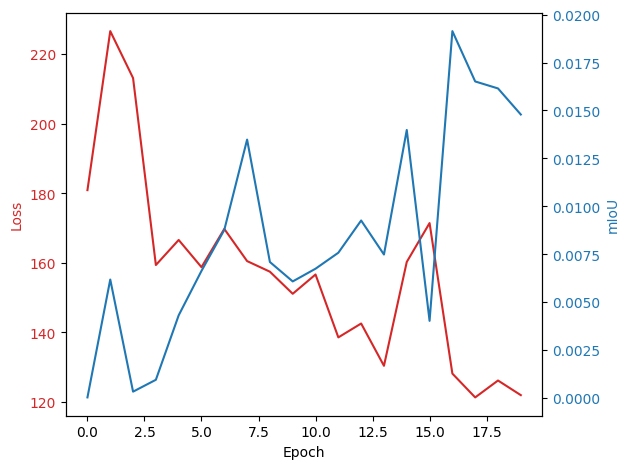

Training epoch 20


100%|██████████| 75/75 [00:28<00:00,  2.67batch/s, loss=145] 


- Log loss: 136.92156982421875
- mIoU: 0.018795853480696678
Training epoch 21


100%|██████████| 75/75 [00:26<00:00,  2.79batch/s, loss=128] 


- Log loss: 123.67182159423828
- mIoU: 0.03375459834933281
Training epoch 22


100%|██████████| 75/75 [00:29<00:00,  2.57batch/s, loss=70.6]


- Log loss: 119.46085357666016
- mIoU: 0.029749741777777672
Training epoch 23


100%|██████████| 75/75 [00:26<00:00,  2.79batch/s, loss=99]  


- Log loss: 117.31378173828125
- mIoU: 0.026227205991744995
Training epoch 24


100%|██████████| 75/75 [00:26<00:00,  2.81batch/s, loss=90]  


- Log loss: 139.72402954101562
- mIoU: 0.014085165224969387
Training epoch 25


100%|██████████| 75/75 [00:26<00:00,  2.79batch/s, loss=197] 


- Log loss: 127.1355209350586
- mIoU: 0.015463798306882381
Training epoch 26


100%|██████████| 75/75 [00:26<00:00,  2.80batch/s, loss=142] 


- Log loss: 126.17961883544922
- mIoU: 0.02260773256421089
Training epoch 27


100%|██████████| 75/75 [00:26<00:00,  2.82batch/s, loss=120] 


- Log loss: 115.26686096191406
- mIoU: 0.026475658640265465
Training epoch 28


100%|██████████| 75/75 [00:26<00:00,  2.79batch/s, loss=135] 


- Log loss: 116.07847595214844
- mIoU: 0.026887260377407074
Training epoch 29


100%|██████████| 75/75 [00:27<00:00,  2.76batch/s, loss=87.6]


- Log loss: 112.1970443725586
- mIoU: 0.026398297399282455
Training epoch 30


100%|██████████| 75/75 [00:26<00:00,  2.79batch/s, loss=167] 


- Log loss: 121.16654205322266
- mIoU: 0.023104149848222733
Training epoch 31


100%|██████████| 75/75 [00:26<00:00,  2.81batch/s, loss=78.6]


- Log loss: 135.03855895996094
- mIoU: 0.02341652661561966
Training epoch 32


100%|██████████| 75/75 [00:27<00:00,  2.75batch/s, loss=132] 


- Log loss: 111.46988677978516
- mIoU: 0.03176788613200188
Training epoch 33


100%|██████████| 75/75 [00:26<00:00,  2.80batch/s, loss=100] 


- Log loss: 106.15486145019531
- mIoU: 0.03998982161283493
Training epoch 34


100%|██████████| 75/75 [00:26<00:00,  2.82batch/s, loss=96.5]


- Log loss: 133.93153381347656
- mIoU: 0.01736447960138321
Training epoch 35


100%|██████████| 75/75 [00:29<00:00,  2.56batch/s, loss=98.9]


- Log loss: 103.46588897705078
- mIoU: 0.03537040948867798
Training epoch 36


100%|██████████| 75/75 [00:27<00:00,  2.76batch/s, loss=76.6]


- Log loss: 121.78633880615234
- mIoU: 0.0198915246874094
Training epoch 37


100%|██████████| 75/75 [00:27<00:00,  2.71batch/s, loss=78.5]


- Log loss: 100.65888214111328
- mIoU: 0.030915038660168648
Training epoch 38


100%|██████████| 75/75 [00:27<00:00,  2.73batch/s, loss=79.5]


- Log loss: 131.6272430419922
- mIoU: 0.020868822932243347
Training epoch 39


100%|██████████| 75/75 [00:27<00:00,  2.68batch/s, loss=102] 


- Log loss: 106.24011993408203
- mIoU: 0.03084213100373745


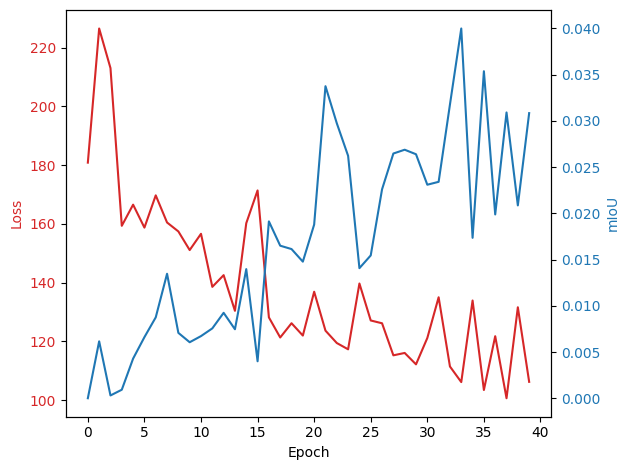

Training epoch 40


100%|██████████| 75/75 [00:26<00:00,  2.79batch/s, loss=149] 


- Log loss: 106.60999298095703
- mIoU: 0.03315979987382889
Training epoch 41


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=89.3]


- Log loss: 101.83712768554688
- mIoU: 0.02957175113260746
Training epoch 42


100%|██████████| 75/75 [00:26<00:00,  2.82batch/s, loss=58.4]


- Log loss: 106.6444091796875
- mIoU: 0.03513338044285774
Training epoch 43


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=67.9]


- Log loss: 107.1781234741211
- mIoU: 0.03224955126643181
Training epoch 44


100%|██████████| 75/75 [00:27<00:00,  2.72batch/s, loss=78.2]


- Log loss: 143.625
- mIoU: 0.01733648031949997
Training epoch 45


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=82.6]


- Log loss: 104.71646881103516
- mIoU: 0.03284681588411331
Epoch 00046: reducing learning rate of group 0 to 5.0000e-05.
Training epoch 46


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=78.2]


- Log loss: 90.39482879638672
- mIoU: 0.03416396677494049
Training epoch 47


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=116] 


- Log loss: 86.34031677246094
- mIoU: 0.04203592985868454
Training epoch 48


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=63.2]


- Log loss: 87.73920440673828
- mIoU: 0.036851149052381516
Training epoch 49


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=64.7]


- Log loss: 85.68619537353516
- mIoU: 0.04260864481329918
Training epoch 50


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=75]  


- Log loss: 85.72757720947266
- mIoU: 0.03957219421863556
Training epoch 51


100%|██████████| 75/75 [00:27<00:00,  2.74batch/s, loss=132] 


- Log loss: 91.66629028320312
- mIoU: 0.03917430713772774
Training epoch 52


100%|██████████| 75/75 [00:27<00:00,  2.76batch/s, loss=84.4]


- Log loss: 82.62084197998047
- mIoU: 0.03901813551783562
Training epoch 53


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=43.2]


- Log loss: 85.51193237304688
- mIoU: 0.06374255567789078
Training epoch 54


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=117] 


- Log loss: 84.23869323730469
- mIoU: 0.03683549165725708
Training epoch 55


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=50.5]


- Log loss: 85.54190063476562
- mIoU: 0.03855990990996361
Training epoch 56


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=80.8]


- Log loss: 86.70858001708984
- mIoU: 0.04079167917370796
Training epoch 57


100%|██████████| 75/75 [00:27<00:00,  2.77batch/s, loss=49.9]


- Log loss: 93.29728698730469
- mIoU: 0.03643423318862915
Training epoch 58


100%|██████████| 75/75 [00:26<00:00,  2.82batch/s, loss=58.6]


- Log loss: 87.770263671875
- mIoU: 0.04006033018231392
Training epoch 59


100%|██████████| 75/75 [00:27<00:00,  2.77batch/s, loss=77.2]


- Log loss: 91.93235778808594
- mIoU: 0.0394480936229229


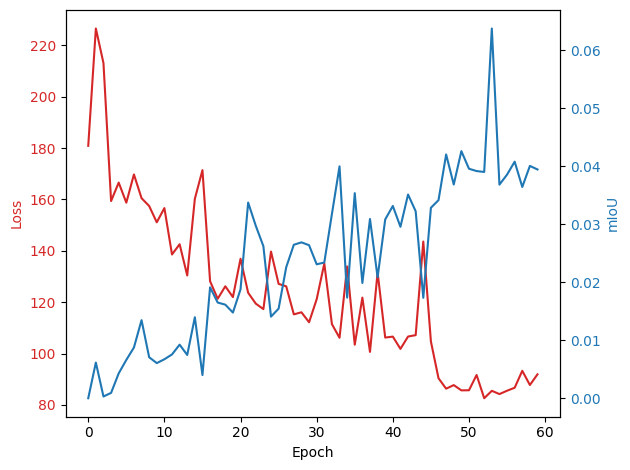

Training epoch 60


100%|██████████| 75/75 [00:27<00:00,  2.72batch/s, loss=105] 


- Log loss: 98.17281341552734
- mIoU: 0.036160558462142944
Epoch 00061: reducing learning rate of group 0 to 2.5000e-05.
Training epoch 61


100%|██████████| 75/75 [00:28<00:00,  2.63batch/s, loss=54.7]


- Log loss: 88.47930145263672
- mIoU: 0.04355187341570854
Training epoch 62


100%|██████████| 75/75 [00:27<00:00,  2.71batch/s, loss=57]  


- Log loss: 81.17195129394531
- mIoU: 0.042684003710746765
Training epoch 63


100%|██████████| 75/75 [00:27<00:00,  2.71batch/s, loss=63.8]


- Log loss: 85.60663604736328
- mIoU: 0.0423867367208004
Training epoch 64


100%|██████████| 75/75 [00:29<00:00,  2.51batch/s, loss=71.3]


- Log loss: 84.27206420898438
- mIoU: 0.039001885801553726
Training epoch 65


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=47.2]


- Log loss: 81.09371185302734
- mIoU: 0.039514269679784775
Training epoch 66


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=51.2]


- Log loss: 84.32730865478516
- mIoU: 0.0423380509018898
Training epoch 67


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=37]  


- Log loss: 90.29822540283203
- mIoU: 0.039315856993198395
Training epoch 68


100%|██████████| 75/75 [00:27<00:00,  2.76batch/s, loss=70.9]


- Log loss: 82.78201293945312
- mIoU: 0.04342683404684067
Training epoch 69


100%|██████████| 75/75 [00:33<00:00,  2.26batch/s, loss=48.7]


- Log loss: 81.05672454833984
- mIoU: 0.04500679299235344
Training epoch 70


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=35.3]


- Log loss: 81.42625427246094
- mIoU: 0.03995392844080925
Training epoch 71


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=55.8]


- Log loss: 80.96633911132812
- mIoU: 0.04297897592186928
Training epoch 72


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=56.1]


- Log loss: 82.66765594482422
- mIoU: 0.043832164257764816
Training epoch 73


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=55.1]


- Log loss: 80.92982482910156
- mIoU: 0.04355805739760399
Training epoch 74


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=30.6]


- Log loss: 82.10411071777344
- mIoU: 0.04249187186360359
Training epoch 75


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=66.2]


- Log loss: 83.29878997802734
- mIoU: 0.04157034680247307
Training epoch 76


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=77.9]


- Log loss: 84.94950103759766
- mIoU: 0.04273180291056633
Training epoch 77


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=52.5]


- Log loss: 85.91496276855469
- mIoU: 0.039878591895103455
Training epoch 78


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=75.6]


- Log loss: 86.3311767578125
- mIoU: 0.0441444031894207
Training epoch 79


100%|██████████| 75/75 [00:27<00:00,  2.78batch/s, loss=45.2]


- Log loss: 80.68816375732422
- mIoU: 0.04285188019275665


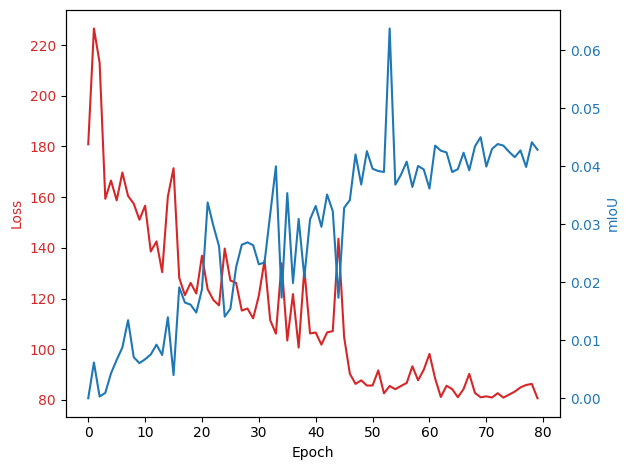

Training epoch 80


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=68.9]


- Log loss: 77.9876708984375
- mIoU: 0.04493923857808113
Training epoch 81


100%|██████████| 75/75 [00:27<00:00,  2.78batch/s, loss=29.8]


- Log loss: 72.3084716796875
- mIoU: 0.046536363661289215
Training epoch 82


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=29.9]


- Log loss: 86.98763275146484
- mIoU: 0.04048333689570427
Training epoch 83


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=52]  


- Log loss: 82.89878845214844
- mIoU: 0.0446464866399765
Training epoch 84


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=40.9]


- Log loss: 79.32914733886719
- mIoU: 0.03920048475265503
Training epoch 85


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=73.2]


- Log loss: 82.171630859375
- mIoU: 0.04520532488822937
Training epoch 86


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=36]  


- Log loss: 79.68631744384766
- mIoU: 0.04410667344927788
Training epoch 87


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=51.8]


- Log loss: 89.66630554199219
- mIoU: 0.043378714472055435
Training epoch 88


100%|██████████| 75/75 [00:26<00:00,  2.82batch/s, loss=56.7]


- Log loss: 84.31016540527344
- mIoU: 0.03856195881962776
Training epoch 89


100%|██████████| 75/75 [00:27<00:00,  2.76batch/s, loss=60.3]


- Log loss: 79.30323791503906
- mIoU: 0.03922946751117706
Epoch 00090: reducing learning rate of group 0 to 1.2500e-05.
Training epoch 90


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=63.9]


- Log loss: 82.78404235839844
- mIoU: 0.04145541042089462
Training epoch 91


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=43.4]


- Log loss: 78.37338256835938
- mIoU: 0.04403776302933693
Training epoch 92


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=62.4]


- Log loss: 83.10641479492188
- mIoU: 0.04343026876449585
Training epoch 93


100%|██████████| 75/75 [00:26<00:00,  2.79batch/s, loss=94.3]


- Log loss: 86.45246124267578
- mIoU: 0.04395892098546028
Training epoch 94


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=41.7]


- Log loss: 78.93905639648438
- mIoU: 0.04356016218662262
Training epoch 95


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=67.4]


- Log loss: 75.84294891357422
- mIoU: 0.04147368669509888
Training epoch 96


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=37.4]


- Log loss: 81.54553985595703
- mIoU: 0.04385236278176308
Training epoch 97


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=45.3]


- Log loss: 78.0420913696289
- mIoU: 0.04458583518862724
Epoch 00098: reducing learning rate of group 0 to 6.2500e-06.
Training epoch 98


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=77]  


- Log loss: 81.36095428466797
- mIoU: 0.042989324778318405
Training epoch 99


100%|██████████| 75/75 [00:26<00:00,  2.82batch/s, loss=43.7]


- Log loss: 76.97174835205078
- mIoU: 0.04416748508810997


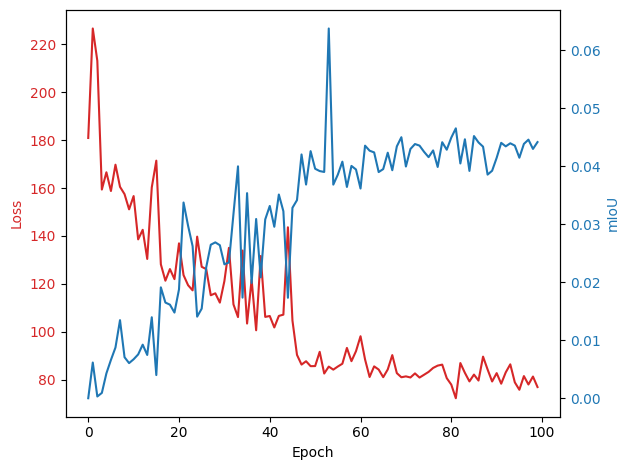

Training epoch 100


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=48.3]


- Log loss: 84.07339477539062
- mIoU: 0.04214423522353172
Training epoch 101


 15%|█▍        | 11/75 [00:04<00:24,  2.65batch/s, loss=36.3]


KeyboardInterrupt: 

In [22]:
# from models import *
# from trainer import *
# from loader import *
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.multivariate_normal import MultivariateNormal
import sys

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn import DataParallel

#python3 train.py 12 FINAL_12/

# Input arguments
# channels = int(sys.argv[1])
# out_dir = sys.argv[2]

channels = 12
out_dir = '/kaggle/working/train_out/'

# Set up 
torch.manual_seed(0)
torch.backends.cudnn.benchmark = True
device = torch.device('cuda')

# Set up model
model = UNet_Attention(img_ch=channels,
            output_ch=1,
            )
# model = Unet(in_channels=channels,
#             out_channels=1,
#             div_factor=1, 
#             prob_output=False)
# model = Res_UNet_Channel_Attention(img_ch=12, output_ch=1)
model = model.to(device)
model = nn.DataParallel(model)

# Set up loss function
# loss_fn = MultiScalePoolingLoss(alpha=0.75, gamma=0.0, itr=4, ratio=[0.4, 0.2, 0.2, 0.3])
loss_fn = HausdorffDT_Focal_Loss(focal_weight = 0.65)

train_dataset = MethaneLoader(device = "cuda", mode="train", plume_id=None, channels=channels)
test_dataset = MethaneLoader(device = "cuda", mode="test", plume_id=None, channels=channels)

#print(train_dataset.__len__())

train_loader = DataLoader(train_dataset, 
                          batch_size = 16, 
                          shuffle = True)

test_loader = DataLoader(test_dataset, 
                          batch_size = 16, 
                          shuffle = True)


# Make the trainer
trainer = Trainer(model,
                  train_loader,
                  test_loader,
                  train_dataset,
                  loss_fn,
                  out_dir,
                  1e-4)

# Train
trainer.train(n_epochs=150)

In [ ]:
### for clearing directory
### skip it
#!rm -rf /kaggle/working/*

In [23]:
def visualize(idx):
    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)

    print(image1.shape, image2.shape, image3.shape)

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()

In [25]:
from matplotlib import pyplot as plt
import torch
import numpy as np
from tqdm import tqdm

# from models import *
# from trainer import *
# from loader import *

from torch.utils.data import DataLoader
from glob import glob

# python3 gen_eval_preds.py 12 final_12_all/ final_12_preds/ 0
# in_dir = sys.argv[2]
# out_dir = sys.argv[3]
# channels = int(sys.argv[1])
# alli_yn = bool(int(sys.argv[4]))

in_dir = "/kaggle/working/train_out/"
out_dir = "/kaggle/working/eval_out/"
channels = 12
alli_yn = False

print("Loading losses...")
losses = np.load(in_dir+"losses.npy")
best_epoch = np.argmin(losses)
print('best epoch: ', best_epoch)

device = torch.device('cuda')

# Set up model
model = UNet_Attention(img_ch=channels,
            output_ch=1,
            )
# model = Unet(in_channels=channels,
#             out_channels=1,
#             div_factor=1, 
#             prob_output=False)
# model = Res_UNet_Channel_Attention(img_ch=12, output_ch=1)
model = model.to(device)
model = nn.DataParallel(model)

model.load_state_dict(torch.load(in_dir+"final_model",
                      map_location=torch.device('cuda'))["model_state_dict"])
# model.load_state_dict(torch.load('/kaggle/input/ch4net_attention/pytorch/default/1/final_model',
#                       map_location=torch.device('cuda'))["model_state_dict"])
model.eval()
print()

Loading losses...
best epoch:  81



In [26]:
import torch
import numpy as np

def calculate_iou(pred, target):
    """
    Calculate Intersection over Union (IoU)
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    intersection = np.logical_and(target, pred)
    union = np.logical_or(target, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_accuracy(pred, target):
    """
    Calculate pixel-wise accuracy
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    correct = np.sum(pred == target)
    total = pred.size
    return correct / total

In [27]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import balanced_accuracy_score

def calculate_metrics(pred, target, epsilon=1e-6):
    """
    Calculate IoU, Accuracy, Recall, Balanced Accuracy, False Positive Rate, and False Negative Rate
    """
    pred = F.sigmoid(torch.tensor(pred)).numpy()
    pred = pred > 0.5 # Convert to binary mask
    target = target > 0  # Convert to binary mask
    
    true_positive = np.sum(np.logical_and(pred, target))
    false_positive = np.sum(np.logical_and(pred, np.logical_not(target)))
    false_negative = np.sum(np.logical_and(np.logical_not(pred), target))
    true_negative = np.sum(np.logical_and(np.logical_not(pred), np.logical_not(target)))
    
    # IoU
    union = np.sum(np.logical_or(pred, target))
    iou = (true_positive + epsilon) / (union + epsilon)
    
    # Accuracy
    total = pred.size
    accuracy = (true_positive + true_negative) / total
    
    # Recall (True Positive Rate)
    recall = (true_positive + epsilon) / (true_positive + false_negative + epsilon)
    
    # False Positive Rate
    fpr = (false_positive + epsilon) / (false_positive + true_negative + epsilon)
    
    # False Negative Rate
    fnr = (false_negative + epsilon) / (false_negative + true_positive + epsilon)
    
    # Balanced Accuracy
#     balanced_acc = balanced_accuracy_score(target.flatten(), pred.flatten())
    balanced_acc = None
    
    return iou, accuracy, recall, balanced_acc, fpr, fnr

# ... [Previous imports and setup code remains the same]

losses = []
ious = []
accuracies = []
recalls = []
balanced_accs = []
fprs = []
fnrs = []

# Iterate over each plume
for i in tqdm(range(250)):
    preds = []
    targets = []

    test_dataset = MethaneLoader(
        device="cuda", mode="val", alli=alli_yn, plume_id=i, channels=channels)

    val_loader = DataLoader(test_dataset,
                            batch_size=64,
                            shuffle=False)

    for batch in val_loader:
        out = model(batch["pred"])
        preds.append(np.squeeze(out).cpu())
        targets.append(np.squeeze(batch["target"]).cpu())
        loss_val = loss_fn(np.squeeze(out).unsqueeze(0), np.squeeze(batch["target"]).unsqueeze(0))
        losses.append(loss_val.item())
        
    if len(preds) > 0:
        preds = torch.concat(preds, dim=0).detach().numpy()
        targets = torch.concat(targets, dim=0).detach().numpy()

        # Calculate metrics for this plume
        iou, accuracy, recall, balanced_acc, fpr, fnr = calculate_metrics(preds, targets)
        
        ious.append(iou)
        accuracies.append(accuracy)
        recalls.append(recall)
        balanced_accs.append(balanced_acc)
        fprs.append(fpr)
        fnrs.append(fnr)
        
        preds = F.sigmoid(torch.tensor(preds)).numpy()
        preds = preds > 0.5 # Convert to binary mask
        np.save(out_dir+f"out_{i}.npy", preds)
        np.save(out_dir+f"target_{i}.npy", targets)

# Calculate and print overall metrics
mean_loss = np.mean(losses)
mean_iou = np.mean(ious)
mean_accuracy = np.mean(accuracies)
mean_recall = np.mean(recalls)
# mean_balanced_acc = np.mean(balanced_accs)
mean_fpr = np.mean(fprs)
mean_fnr = np.mean(fnrs)

print(f"Mean Loss: {mean_loss:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
# print(f"Mean Balanced Accuracy: {mean_balanced_acc:.4f}")
print(f"Mean False Positive Rate: {mean_fpr:.4f}")
print(f"Mean False Negative Rate: {mean_fnr:.4f}")

# Save metrics
np.save(out_dir+"metrics.npy", {
    "loss": mean_loss,
    "iou": mean_iou,
    "accuracy": mean_accuracy,
    "recall": mean_recall,
#     "balanced_accuracy": mean_balanced_acc,
    "false_positive_rate": mean_fpr,
    "false_negative_rate": mean_fnr
})

100%|██████████| 250/250 [00:27<00:00,  8.94it/s]

Mean Loss: 120.1176
Mean IoU: 0.5756
Mean Accuracy: 0.9829
Mean Recall: 0.7193
Mean False Positive Rate: 0.0072
Mean False Negative Rate: 0.7948


pos
7.366071635343589


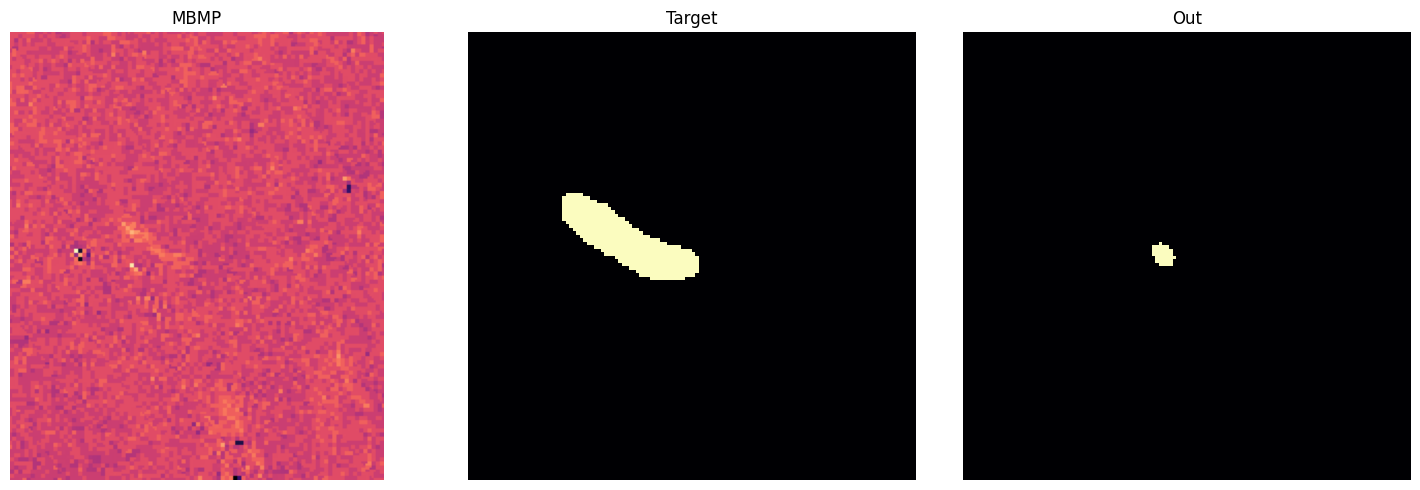

neg
1.5151514921946743e-06


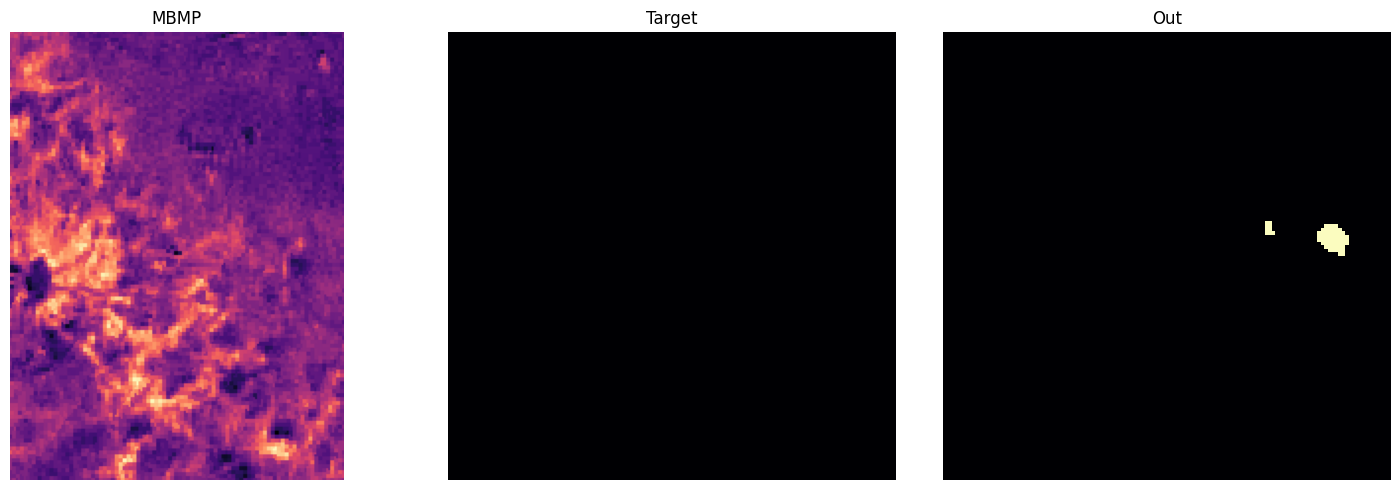

neg
1.5151514921946743e-06


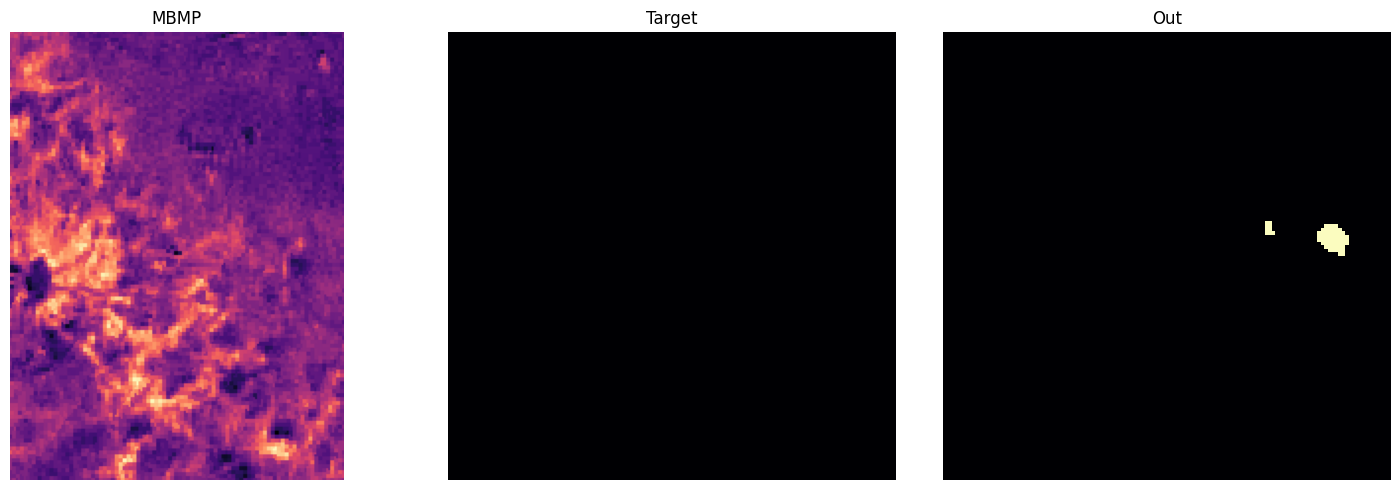

pos
31.519274454059783


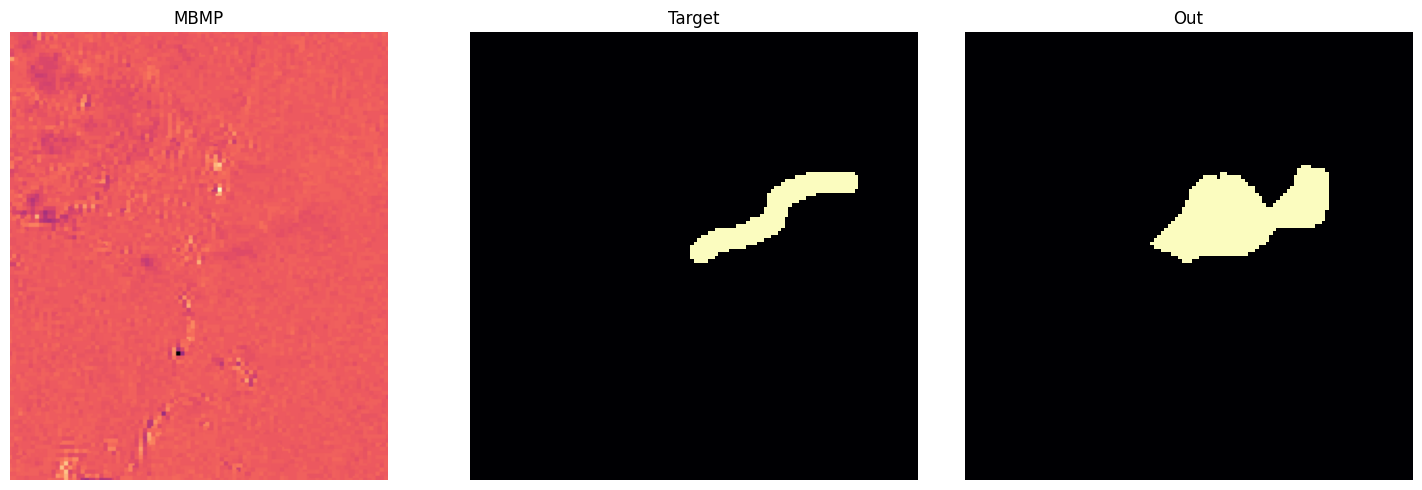

pos
12.449799372590764


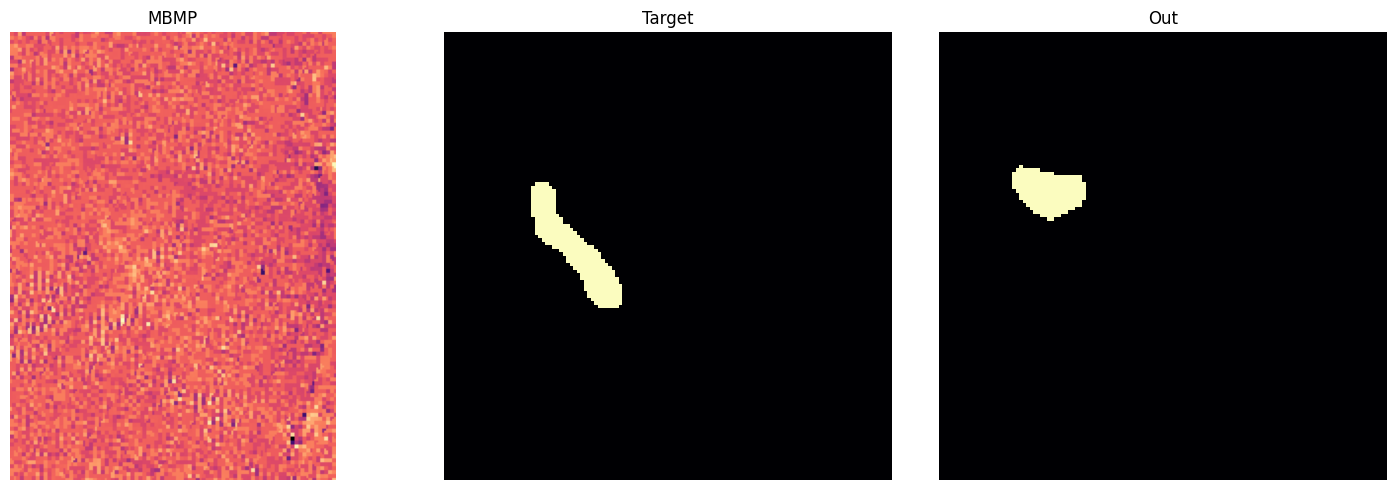

neg
100.0


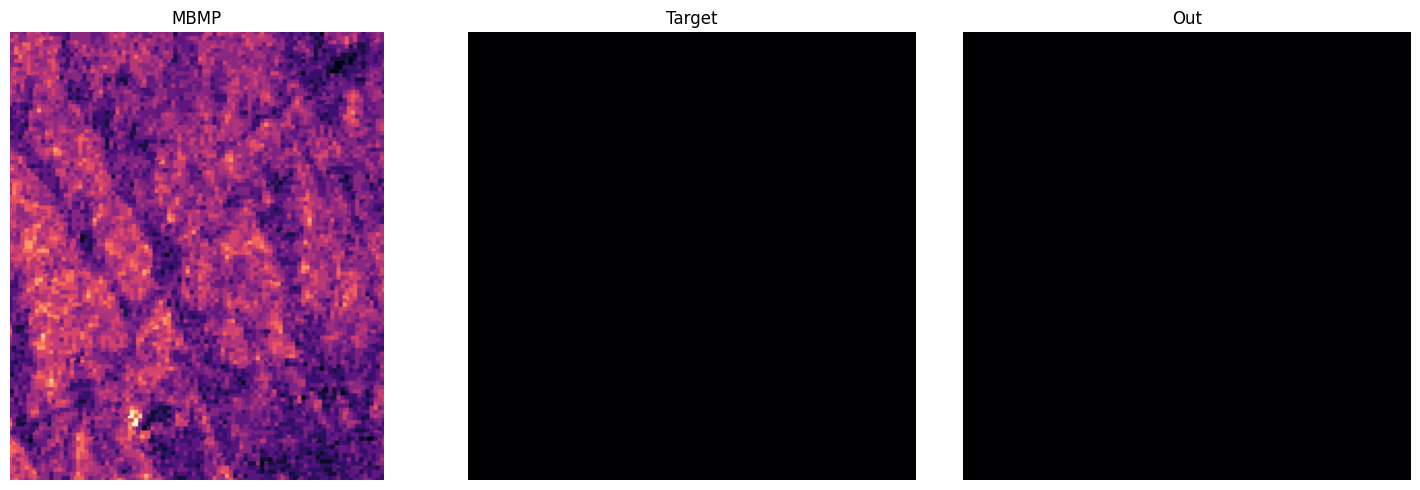

neg
100.0


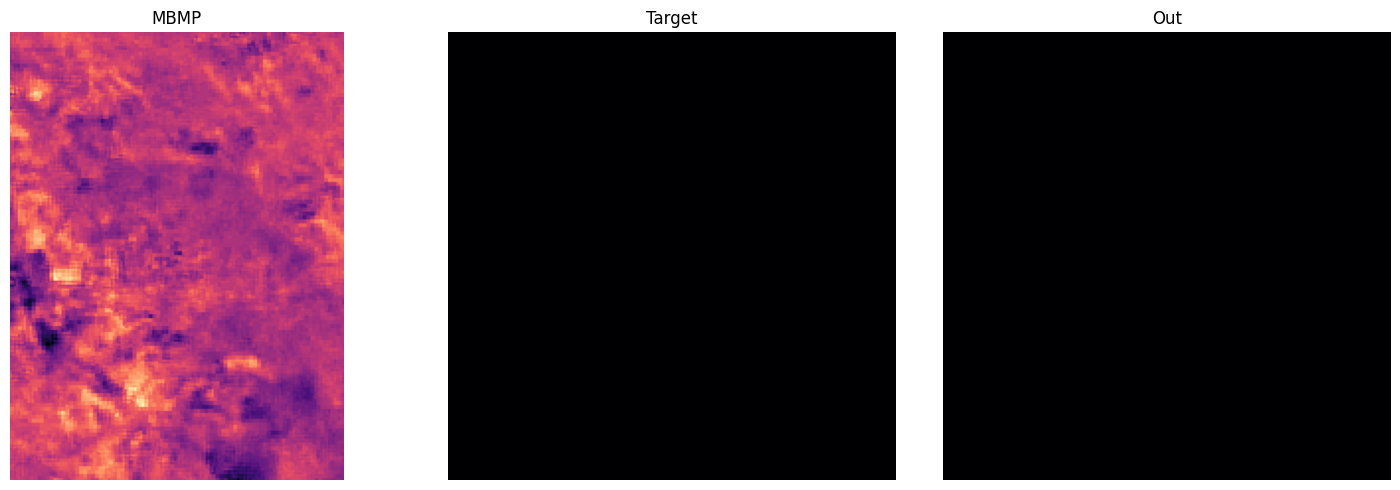

neg
100.0


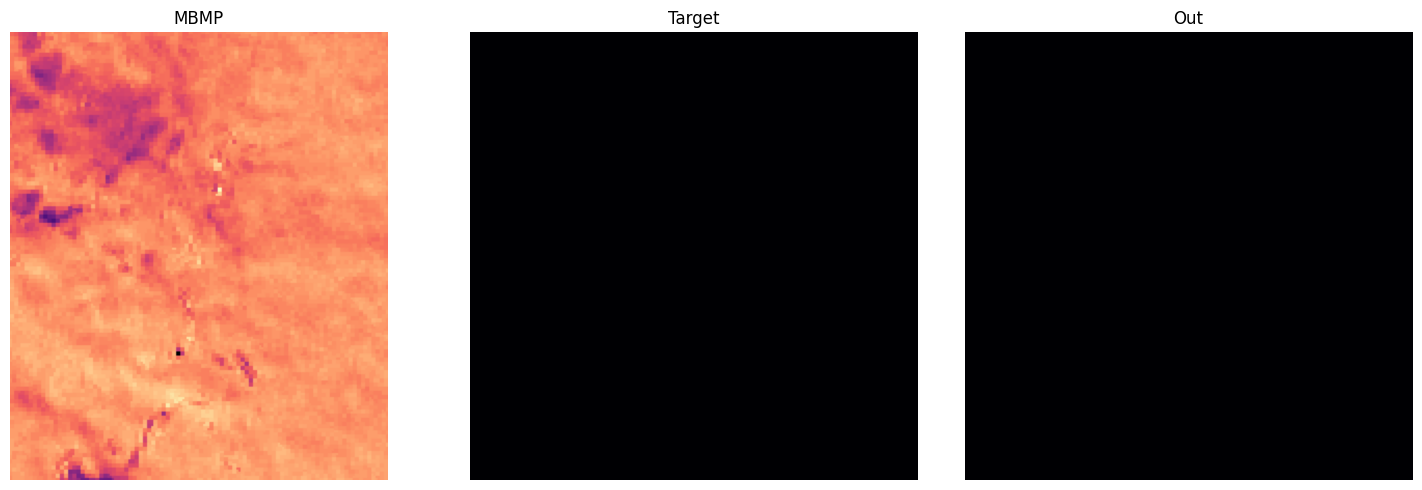

neg
100.0


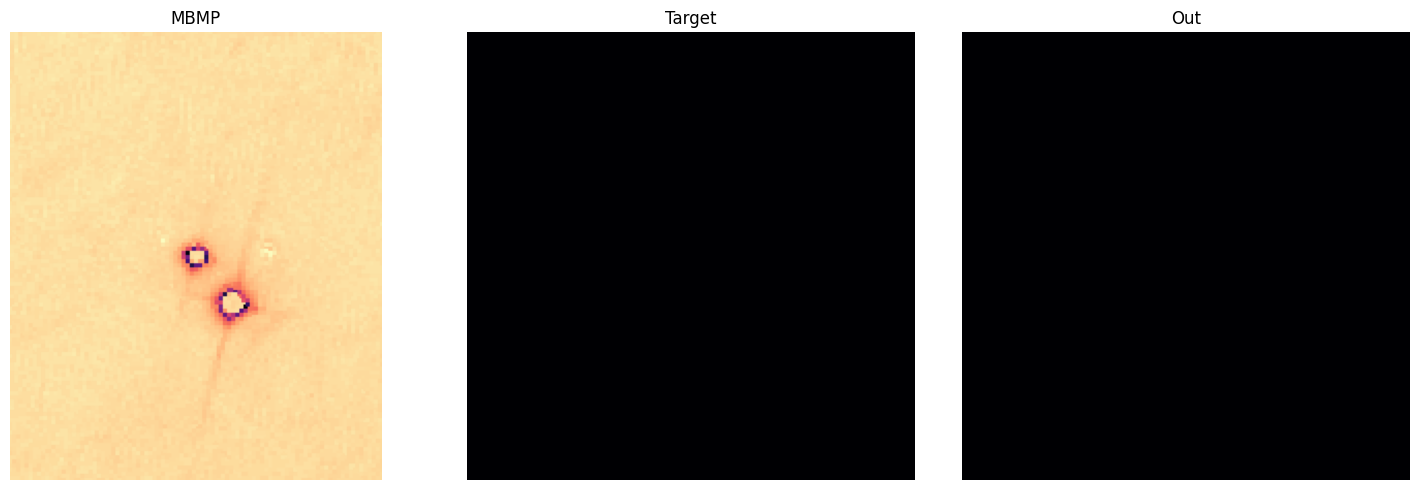

neg
100.0


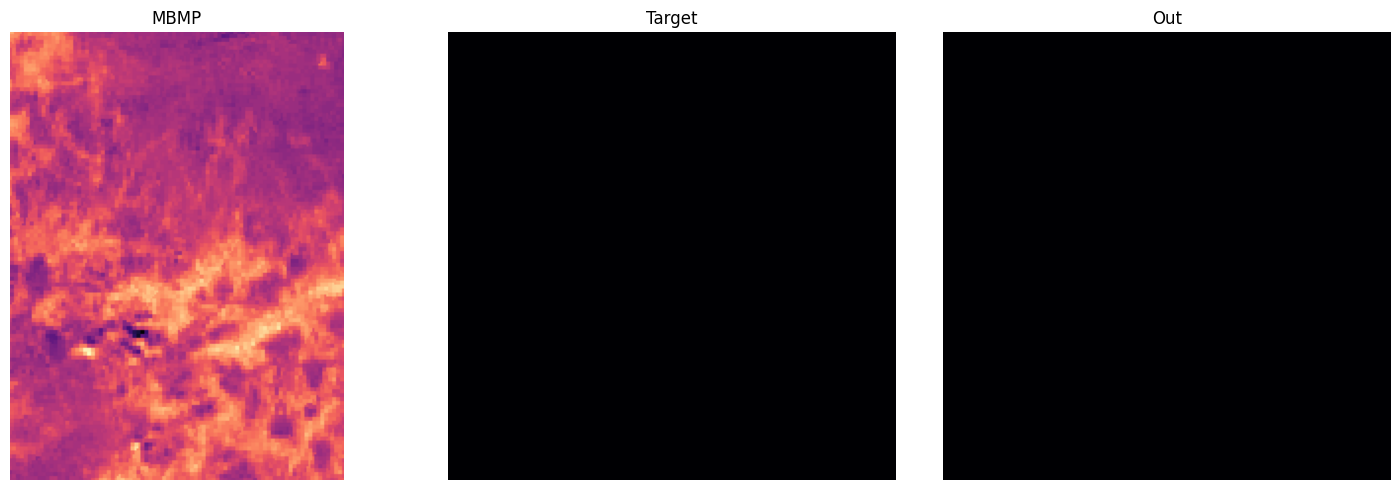

neg
100.0


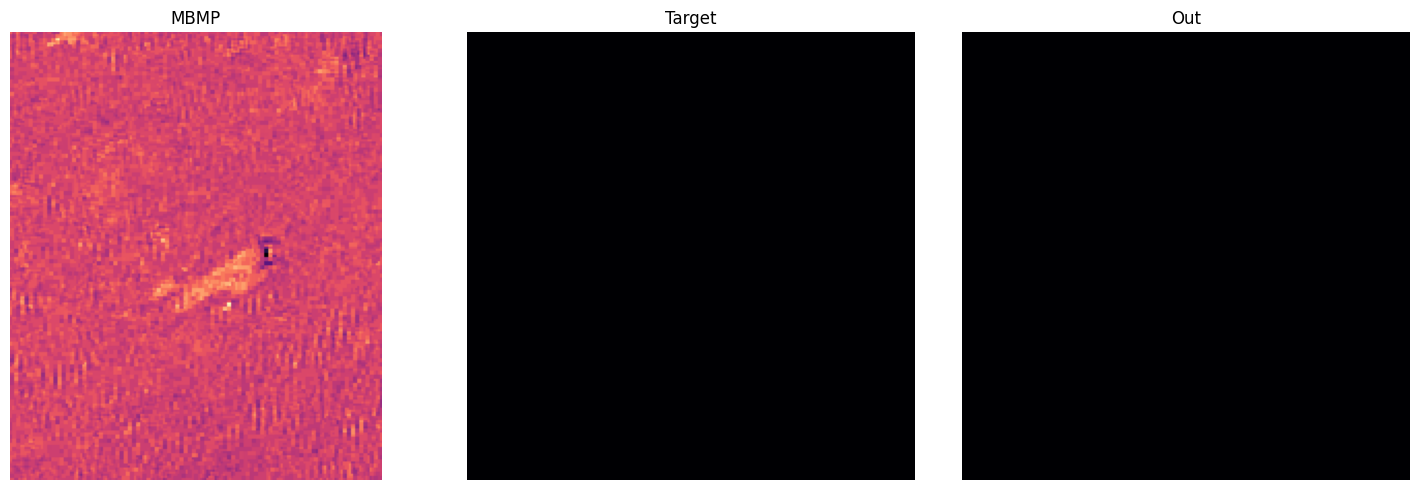

pos
31.519274454059783


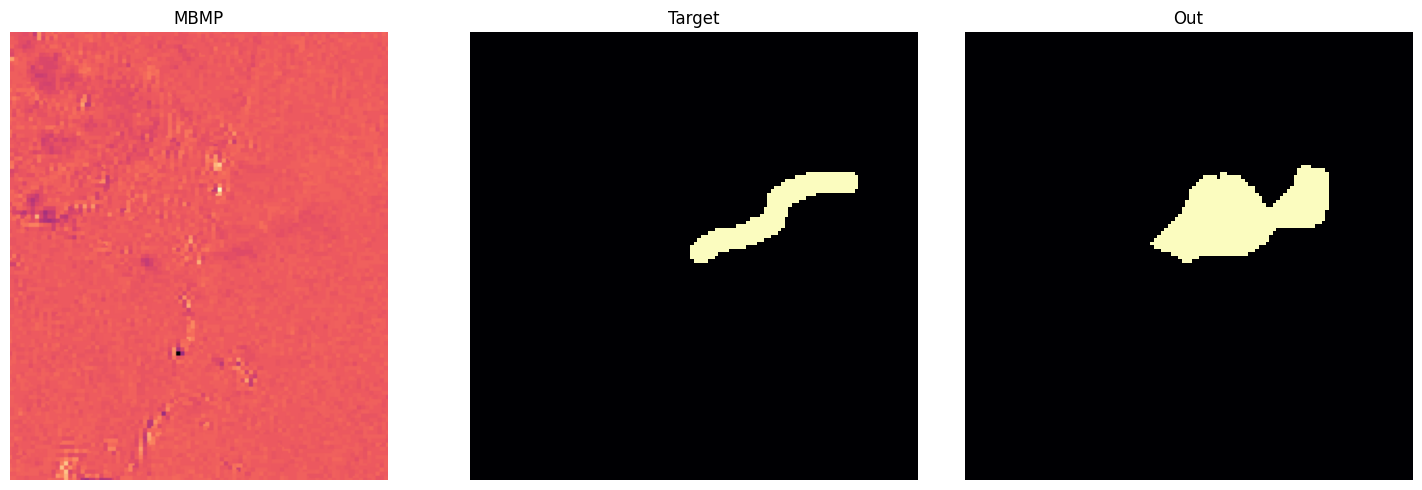

neg
100.0


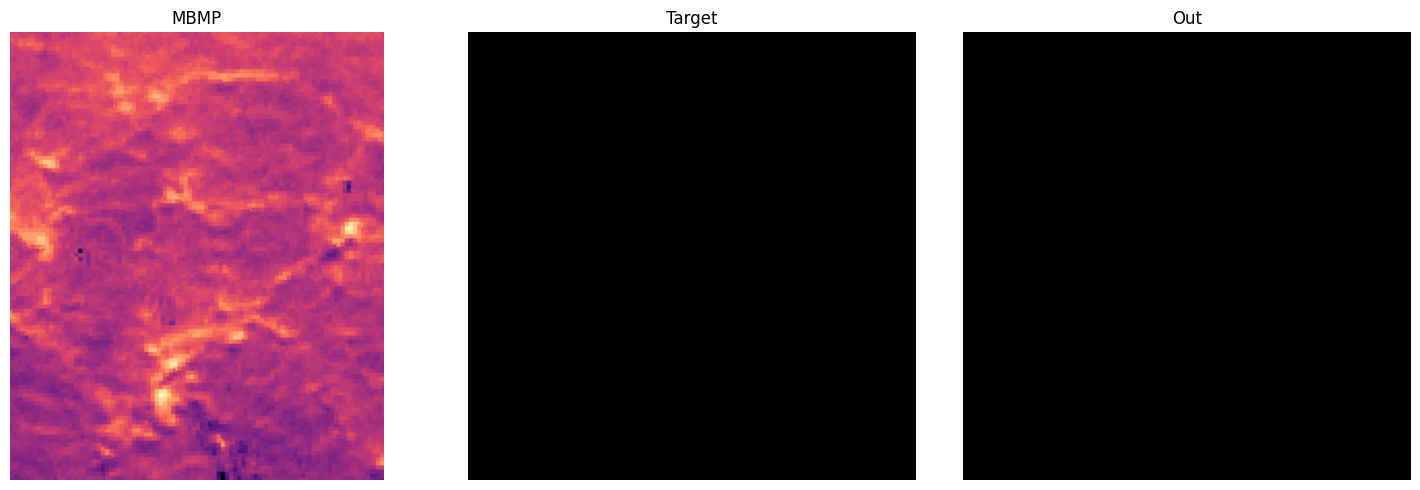

pos
7.042253471533426e-07


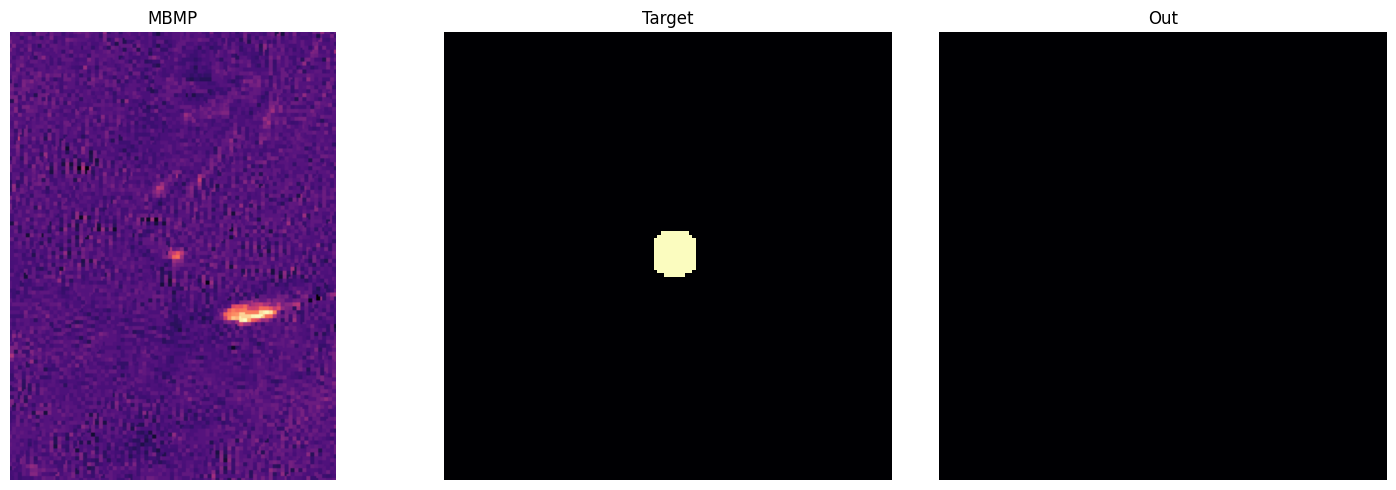

neg
100.0


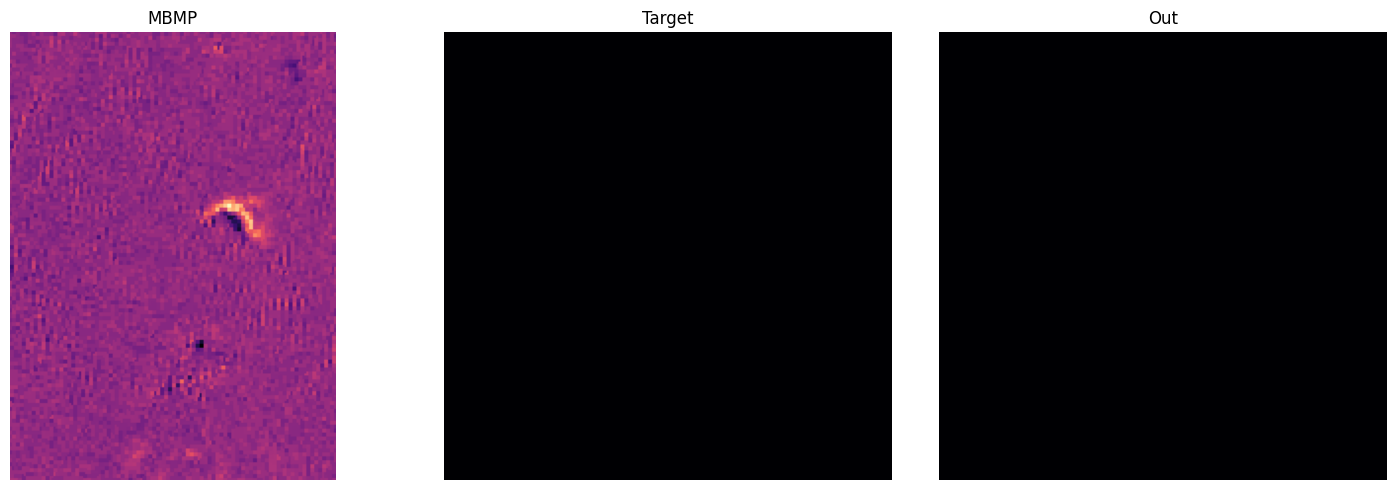

neg
100.0


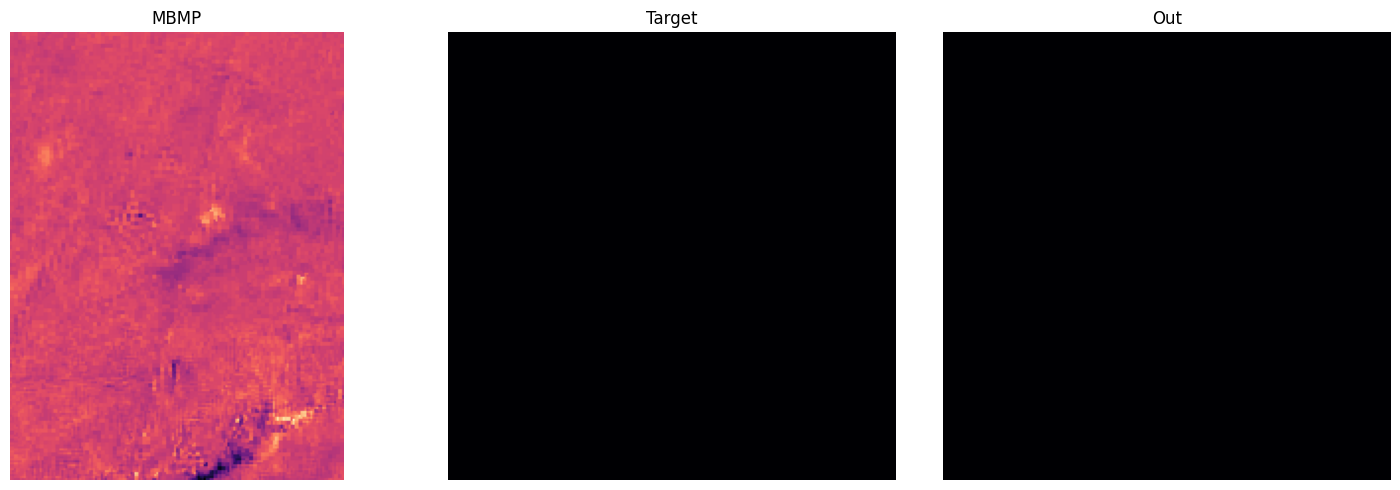

pos
69.34964586648445


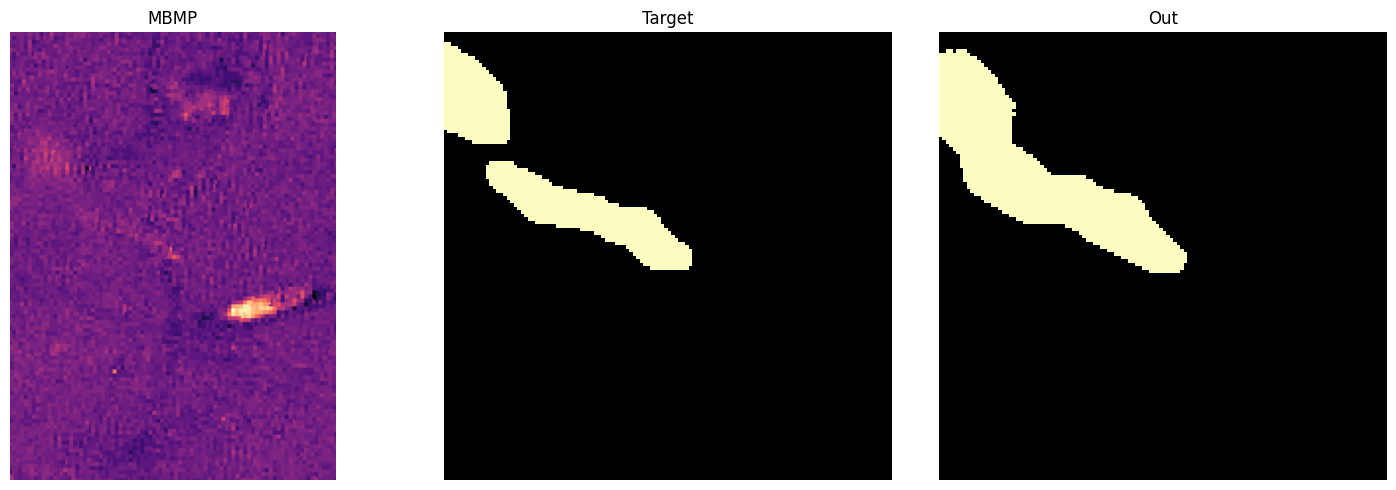

neg
100.0


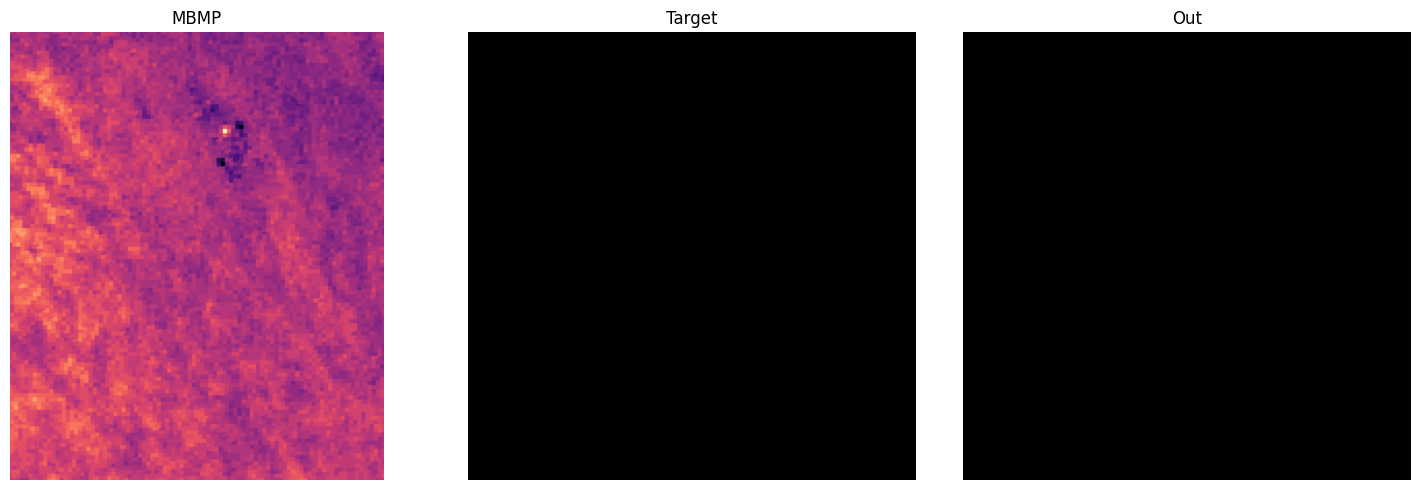

neg
100.0


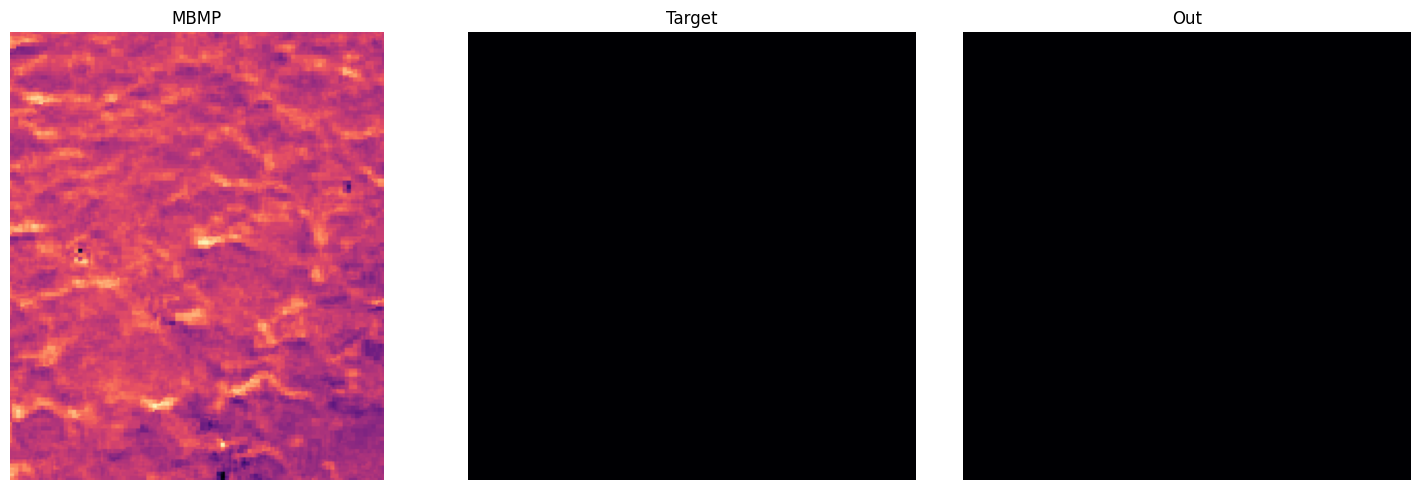

neg
100.0


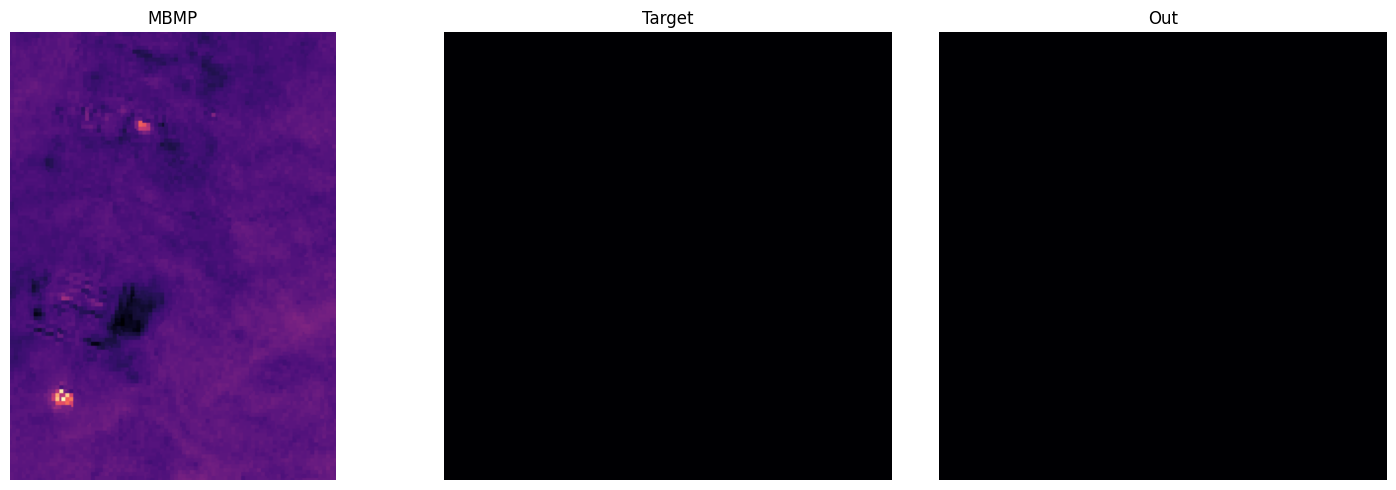

In [29]:
# from glob import glob

# visualize masks
samples = 250

# def visualize(idx):
    
for i in range(samples):
    idx = np.random.randint(0, samples)
#     idx = i

    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)
#     print(image2.shape)
    
    eps = 1e-6
    pred = image3
    target = image2
    iou = (np.sum(np.logical_and(pred, target)) + eps) / (np.sum(np.logical_or(pred, target)) + eps) * 100
    
    print(iou)

#     print(image1.shape, image2.shape, image3.shape)
#     print(losses[idx])

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()
    
    i = i + 1
    if(i==20): break
